## Import

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 7.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 8.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 11.5 MB/s eta 0:00:00a 0:00:01


In [ ]:
import transformers
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from collections import defaultdict
from review_dataset import ReviewDataset
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [ ]:
from transformers import pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

/opt/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /opt/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <0E72DC1D-5515-3805-A3DE-7FD4A5B0B34D> /opt/anaconda3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

## Data

In [ ]:
df = pd.read_csv('clean_data.csv')

In [ ]:
df_to_train = df[:25000]
df_to_train.sentiment.value_counts()

sentiment
0    12526
1    12474
Name: count, dtype: int64

In [ ]:
df_to_test = df[25000:27500]
df_to_test.sentiment.value_counts()

sentiment
1    1297
0    1203
Name: count, dtype: int64

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

In [ ]:
token_lens = []

for txt in df.review:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

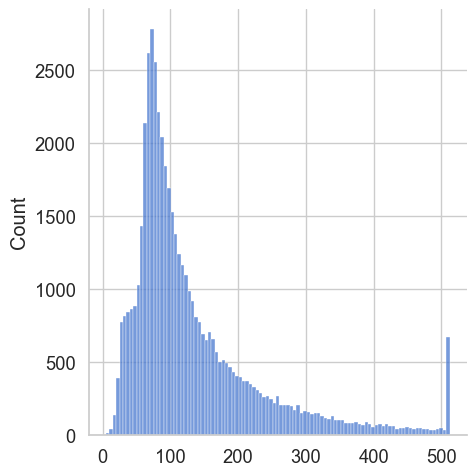

In [ ]:
sns.displot(token_lens)

In [ ]:

"""
class ReviewDataset(Dataset):
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, item):
        review = str(self.review[item])
        target = self.target[item]

        encoding = self.tokenizer.encode_plus(
            review,
            max_length = self.max_len,
            add_special_tokens = True,
            pad_to_max_length = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            return_tensors = 'pt' )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

"""


Proper storage of interactively declared classes (or instances
of those classes) is not possible! Only instances
of classes in real modules on file system can be %store'd.



In [ ]:
MAX_LEN = 200
BATCH_SIZE = 16
EPOCHS = 20

In [ ]:
df_train, df_test = train_test_split(df_to_train, test_size = 0.2, random_state = random_seed)
df_val, df_test = train_test_split(df_to_test, test_size = 0.5, random_state = random_seed)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((20000, 2), (1250, 2), (1250, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        review = df.review.to_numpy(),
        target = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len)

    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'target'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['target'].shape)

torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


## 2.  Instantiate Model

### Transformer 1

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
nlp = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer, device=0)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1256db010>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/anaconda3/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/anaconda3/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/anaconda3/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/anaconda3/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 
/opt/anaconda3/lib/python3.10/site-packages/transformer

In [ ]:
text = list(df.review.values)

In [ ]:
res = nlp(text, truncation=True)

In [ ]:
pred = [1 if r['label'] == 'POSITIVE' else 0 for r in res]


In [ ]:
df['pred'] = pred
df

In [ ]:
print('Accuracy: ', accuracy_score(df.sentiment.values, pred))
print('Precision: ', precision_score(df.sentiment.values, pred, average=None))
print('Recall: ', recall_score(df.sentiment.values, pred, average=None))

### Transformer 2

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        return_dict=True)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
model = SentimentClassifier(2)
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 200])
torch.Size([16, 200])


In [ ]:
model(input_ids, attention_mask)

tensor([[0.4146, 0.5854],
        [0.3858, 0.6142],
        [0.4703, 0.5297],
        [0.4079, 0.5921],
        [0.4065, 0.5935],
        [0.3599, 0.6401],
        [0.4574, 0.5426],
        [0.3898, 0.6102],
        [0.5569, 0.4431],
        [0.4093, 0.5907],
        [0.6656, 0.3344],
        [0.3969, 0.6031],
        [0.3953, 0.6047],
        [0.4385, 0.5615],
        [0.4489, 0.5511],
        [0.4742, 0.5258]], device='mps:0', grad_fn=<SoftmaxBackward0>)

#### Training

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias = False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples):

    model = model.train()
    losses = []
    correct_preds = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['target'].to(device)

        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask)
        _, pred = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_preds += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_preds.float() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_preds = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['target'].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask)
            _, pred = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_preds += torch.sum(pred == targets)
            losses.append(loss.item())
    return correct_preds.float() / n_examples, np.mean(losses)


In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch +1} / {EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)

    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc



Epoch 1 / 20
----------
Train loss 0.44506067566871643 accuracy 0.866100013256073
Val loss 0.4540573788594596 accuracy 0.8575999736785889

Epoch 2 / 20
----------
Train loss 0.44071427328586577 accuracy 0.8718000054359436
Val loss 0.45862453346011006 accuracy 0.8568000197410583

Epoch 3 / 20
----------
Train loss 0.43446627323627474 accuracy 0.8777999877929688
Val loss 0.44889135488980936 accuracy 0.8543999791145325

Epoch 4 / 20
----------
Train loss 0.4313680054664612 accuracy 0.8816999793052673
Val loss 0.44716219207908536 accuracy 0.864799976348877

Epoch 5 / 20
----------
Train loss 0.42811460916996 accuracy 0.8844000101089478
Val loss 0.4539958996863305 accuracy 0.8623999953269958

Epoch 6 / 20
----------
Train loss 0.42593277926445006 accuracy 0.8863000273704529
Val loss 0.44556558584865136 accuracy 0.8687999844551086

Epoch 7 / 20
----------
Train loss 0.42256339581012725 accuracy 0.8881000280380249
Val loss 0.4546898652481127 accuracy 0.86080002784729

Epoch 8 / 20
----------


In [ ]:
model = SentimentClassifier(2)
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

#### Evaluation

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    pred_probs = []
    real_value = []

    with torch.no_grad():
        for d in data_loader:
            texts = d['review_text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['target'].to(device)

            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask)
            _, pred = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(pred)
            pred_probs.extend(outputs)
            real_value.extend(targets)

    predictions = torch.stack(predictions).cpu()
    pred_probs = torch.stack(pred_probs).cpu()
    real_value = torch.stack(real_value).cpu()
    return review_texts, predictions, pred_probs, real_value




In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [ ]:
test_acc

tensor(0.8872, device='mps:0')

In [ ]:
class_names = ['0', '1']

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       606
           1       0.89      0.89      0.89       644

    accuracy                           0.89      1250
   macro avg       0.89      0.89      0.89      1250
weighted avg       0.89      0.89      0.89      1250



In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')


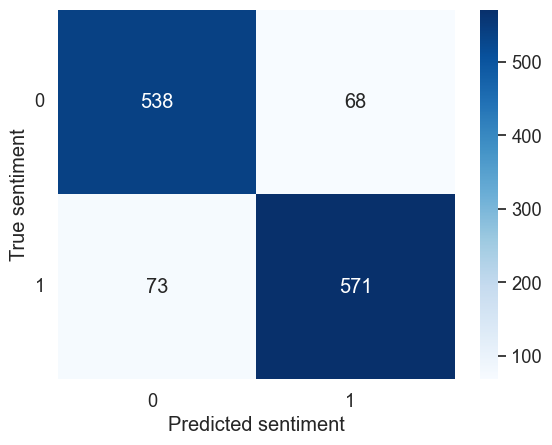

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 10
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})


(0.0, 1.0)

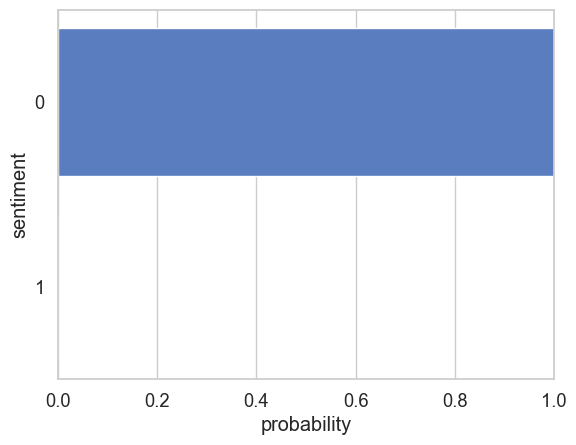

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0,1])